In [76]:
import cv2
import numpy as np
import scipy.io as sio
from scipy.linalg import null_space
import matplotlib.pyplot as plt
import sys
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

In [72]:
def compute_F(pts1, pts2):
    # TO DO
    ## Get 8 random points from pts1 and pts2.
    # print("Shape of pts1, " , pts1.shape)

    row_of_points = np.array([[u_x*v_x, u_y*v_x, v_x, u_x*v_y, u_y*v_y, v_y, u_x, u_y, 1] for ((u_x,u_y),(v_x,v_y)) in zip(pts1,pts2)]) # N,9
    # print("pts1 : ", pts1[:5,:])
    # print("pts2 : ", pts2[:5,:])
    # print("Row of points : ", row_of_points[:5,:])
    # print("Shape of row of points : ", row_of_points.shape)
    ## Apply ransac to get inliners.
    error_thres = 0.0005
    max_inliners = 0
    F = None
    for _ in range(500):
        random_points = np.random.choice(row_of_points.shape[0], 8, replace=False)
        # print("Random Points",random_points)
        eight_points = row_of_points[random_points]       ## 8,9
        # print("Eight points : ", eight_points)
        # print("Eight points shape : ", eight_points.shape)

        F_temp = null_space(eight_points)[:,0].reshape(3,3)  ## Column Matrix 9,1
        # F_temp = null_space(eight_points)
        # if F_temp.shape[1] > 1:
        #     continue
        # F_temp = F_temp.reshape(3,3)
        U, D, VT = np.linalg.svd(F_temp)
        D[2] = 0
        D_new = np.diag(D)
        F_temp = U@D_new@VT
        F_temp = F_temp.reshape(9,1)
        # print("F temp shape : ", F_temp.shape)

        ## Apply F on all the points.
        results = row_of_points@F_temp ## N,1

        error = np.abs(results)
        num_inliners = len(np.where(error < error_thres)[0])

        if num_inliners > max_inliners:
            F = F_temp
            max_inliners = num_inliners
            # print("Max inliners updated to : ", max_inliners)

    F = F.reshape(3,3)
    return F

# data = np.load('./correspondence.npz')
# pts1, pts2 = data['pts1'], data['pts2']

F = compute_F(pts1, pts2)

TypeError: 'numpy.ndarray' object is not callable

In [3]:
def compute_F_2(pts1, pts2):
    # TO DO
    ## Get 8 random points from pts1 and pts2.

    ## Apply ransac to get inliners.
    error_thres = 0.5
    max_inliners = 0
    index_inliners = None
    for _ in range(1000):
        index_points = np.random.choice(pts1.shape[0], 3, replace=False)

        three_points = np.array([[pts1[i][0], pts1[i][1], pts2[i][0], pts2[i][1]] for i in index_points])
        # print("Three Points : \n", three_points)

        M = np.array([[[u, v, 1, 0, 0, 0],[0, 0, 0, u, v, 1]] for [u, v] in three_points[:,:2]]).reshape(6,6)
        # print("M looks like : ", M)

        b = np.array([[u,v] for [u,v] in three_points[:,2:]]).reshape(-1,1)
        # print("b" ,b)

        x = np.matmul( np.matmul( np.linalg.inv( np.matmul(M.T, M)), M.T) , b)
        # print("X",x)

        temp_A = np.vstack((x.reshape(2,3), [0,0,1]))
        # print("Teap A ;", temp_A)

        ## Predict points.
        pts2_pridict = np.hstack((pts1, np.ones((pts1.shape[0],1))))@temp_A.T

        error = np.sum(np.square(pts2_pridict[:,:2] - pts2), axis=1)
        index_inliners_temp = np.where(error < error_thres)[0]
        # print('index_inliners : ', index_inliners)

        if len(index_inliners_temp) > max_inliners:
            index_inliners = index_inliners_temp
            max_inliners = len(index_inliners)
            # print("INdex inliners updates nwe max : ", max_inliners)

    ## Pick 8 points from Inliners.
    rand_indices = np.random.choice(index_inliners, size = 8, replace=False)
    # points = [(pts1[idx][1], pts1[idx][0], pts2[idx][1], pts2[idx][0]) for idx in rand_indices]
    points = [(pts1[idx][0], pts1[idx][1], pts2[idx][0], pts2[idx][1]) for idx in rand_indices]
    A = np.array([[u_x*v_x, u_y*v_x, v_x, u_x*v_y, u_y*v_y, v_y, u_x, u_y, 1] for u_x,u_y,v_x,v_y in points])

    F_naive = null_space(A)[:,0].reshape(3,3)  ## here we are taking only one null space of the matrix
    U, D, VT = np.linalg.svd(F_naive)
    D[2] = 0
    D_new = np.diag(D)
    F = U@D_new@VT
    return F

data = np.load('./correspondence.npz')
pts1, pts2 = data['pts1'], data['pts2']

F = compute_F(pts1, pts2)

In [99]:
def triangulation(P1, P2, pts1, pts2):
    # TO DO
    pts3D = []
    for pt in range(pts1.shape[0]):
        ux, uy = pts1[pt,0], pts1[pt,1]
        vx, vy = pts2[pt,0], pts2[pt,1]
        top_mat = np.array([[0, -1, uy],[1,0,-ux],[-uy,ux,0]])@P1
        bottom_mat = np.array([[0, -1, vy],[1,0,-vx],[-vy,vx,0]])@P2
        ## There will be reduncy in top and bottom matrix.
        A = np.vstack((top_mat[:2,:], bottom_mat[:2,:]))
        M = A[:,:3]
        b = -A[:,3]
        X = np.linalg.inv(M.T@M)@M.T@b
        pts3D.append(X)
    pts3D = np.array(pts3D)
    return pts3D

In [5]:
def disambiguate_pose(Rs, Cs, pts3Ds):
    # TO DO
    return R, C, pts3D


In [6]:
def compute_rectification(K, R, C):
    # TO DO
    return H1, H2

In [7]:
def dense_match(img1, img2, descriptors1, descriptors2):
    # TO DO
    return disparity

In [8]:
def compute_camera_pose(F, K):
    E = K.T @ F @ K
    R_1, R_2, t = cv2.decomposeEssentialMat(E)
    # 4 cases
    R1, t1 = R_1, t
    R2, t2 = R_1, -t
    R3, t3 = R_2, t
    R4, t4 = R_2, -t

    Rs = [R1, R2, R3, R4]
    ts = [t1, t2, t3, t4]
    Cs = []
    for i in range(4):
        Cs.append(-Rs[i].T @ ts[i])
    return Rs, Cs

In [9]:
def visualize_img_pair(img1, img2):
    img = np.hstack((img1, img2))
    if img1.ndim == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [10]:
def visualize_find_match(img1, img2, pts1, pts2):
    assert pts1.shape == pts2.shape, 'x1 and x2 should have same shape!'
    img_h = img1.shape[0]
    scale_factor1 = img_h/img1.shape[0]
    scale_factor2 = img_h/img2.shape[0]
    img1_resized = cv2.resize(img1, None, fx=scale_factor1, fy=scale_factor1)
    img2_resized = cv2.resize(img2, None, fx=scale_factor2, fy=scale_factor2)
    pts1 = pts1 * scale_factor1
    pts2 = pts2 * scale_factor2
    pts2[:, 0] += img1_resized.shape[1]
    img = np.hstack((img1_resized, img2_resized))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    for i in range(pts1.shape[0]):
        plt.plot([pts1[i, 0], pts2[i, 0]], [pts1[i, 1], pts2[i, 1]], 'b.-', linewidth=0.5, markersize=5)
    plt.axis('off')
    plt.show()

In [11]:
def visualize_epipolar_lines(F, pts1, pts2, img1, img2):
    assert pts1.shape == pts2.shape, 'x1 and x2 should have same shape!'
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

    for i in range(pts1.shape[0]):
        x1, y1 = int(pts1[i][0] + 0.5), int(pts1[i][1] + 0.5)
        ax1.scatter(x1, y1, s=5)
        p1, p2 = find_epipolar_line_end_points(img2, F, (x1, y1))
        ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=0.5)

    for i in range(pts2.shape[0]):
        x2, y2 = int(pts2[i][0] + 0.5), int(pts2[i][1] + 0.5)
        ax2.scatter(x2, y2, s=5)
        p1, p2 = find_epipolar_line_end_points(img1, F.T, (x2, y2))
        ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=0.5)

    ax1.axis('off')
    ax2.axis('off')
    plt.show()

In [12]:
def find_epipolar_line_end_points(img, F, p):
    img_width = img.shape[1]
    el = (F @ np.array([[p[0], p[1], 1]]).T).flatten()
    p1, p2 = (0, int(-el[2] / el[1])), (img.shape[1], int((-img_width * el[0] - el[2]) / el[1]))
    _, p1, p2 = cv2.clipLine((0, 0, img.shape[1], img.shape[0]), p1, p2)
    return p1, p2

In [13]:
def visualize_camera_poses(Rs, Cs):
    assert(len(Rs) == len(Cs) == 4)
    fig = plt.figure()
    R1, C1 = np.eye(3), np.zeros((3, 1))
    for i in range(4):
        R2, C2 = Rs[i], Cs[i]
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        draw_camera(ax, R1, C1)
        draw_camera(ax, R2, C2)
        set_axes_equal(ax)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('z axis')
        ax.view_init(azim=-90, elev=0)
        ax.title.set_text('Configuration {}'.format(i))
    fig.tight_layout()
    plt.show()

In [14]:
def visualize_camera_poses_with_pts(Rs, Cs, pts3Ds):
    assert(len(Rs) == len(Cs) == 4)
    fig = plt.figure()
    R1, C1 = np.eye(3), np.zeros((3, 1))
    for i in range(4):
        R2, C2, pts3D = Rs[i], Cs[i], pts3Ds[i]
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        draw_camera(ax, R1, C1, 5)
        draw_camera(ax, R2, C2, 5)
        ax.plot(pts3D[:, 0], pts3D[:, 1], pts3D[:, 2], 'b.')
        set_axes_equal(ax)
        ax.set_xlabel('x axis')
        ax.set_ylabel('y axis')
        ax.set_zlabel('z axis')
        ax.view_init(azim=-90, elev=0)
        ax.title.set_text('Configuration {}'.format(i))
    fig.tight_layout()
    plt.show()

In [15]:
def draw_camera(ax, R, C, scale=0.2):
    axis_end_points = C + scale * R.T  # (3, 3)
    vertices = C + scale * R.T @ np.array([[1, 1, 1], [-1, 1, 1], [-1, -1, 1], [1, -1, 1]]).T  # (3, 4)
    vertices_ = np.hstack((vertices, vertices[:, :1]))  # (3, 5)
    C = C.flatten()  # (3, 1) -> (3,)

    # draw coordinate system of camera
    ax.plot([C[0], axis_end_points[0, 0]], [C[1], axis_end_points[1, 0]], [C[2], axis_end_points[2, 0]], 'r-')
    ax.plot([C[0], axis_end_points[0, 1]], [C[1], axis_end_points[1, 1]], [C[2], axis_end_points[2, 1]], 'g-')
    ax.plot([C[0], axis_end_points[0, 2]], [C[1], axis_end_points[1, 2]], [C[2], axis_end_points[2, 2]], 'b-')

    # draw square window and lines connecting it to camera center
    ax.plot(vertices_[0, :], vertices_[1, :], vertices_[2, :], 'k-')
    ax.plot([C[0], vertices[0, 0]], [C[1], vertices[1, 0]], [C[2], vertices[2, 0]], 'k-')
    ax.plot([C[0], vertices[0, 1]], [C[1], vertices[1, 1]], [C[2], vertices[2, 1]], 'k-')
    ax.plot([C[0], vertices[0, 2]], [C[1], vertices[1, 2]], [C[2], vertices[2, 2]], 'k-')
    ax.plot([C[0], vertices[0, 3]], [C[1], vertices[1, 3]], [C[2], vertices[2, 3]], 'k-')

In [16]:
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range, x_middle = abs(x_limits[1] - x_limits[0]), np.mean(x_limits)
    y_range, y_middle = abs(y_limits[1] - y_limits[0]), np.mean(y_limits)
    z_range, z_middle = abs(z_limits[1] - z_limits[0]), np.mean(z_limits)

    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [17]:
def visualize_disparity_map(disparity):
    disparity[disparity > 150] = 150
    plt.imshow(disparity, cmap='jet')
    plt.show()

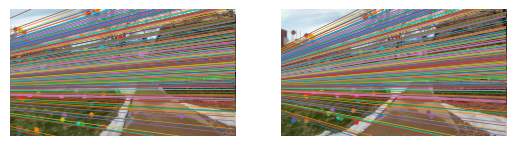

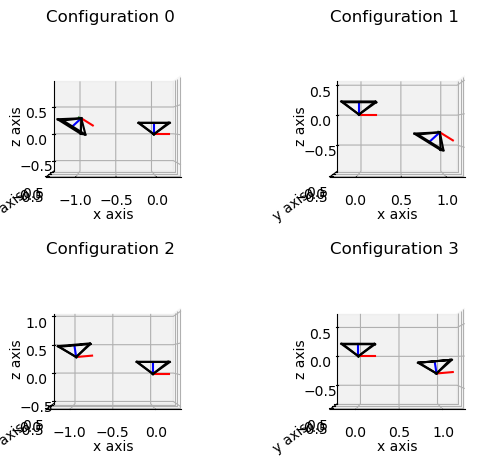

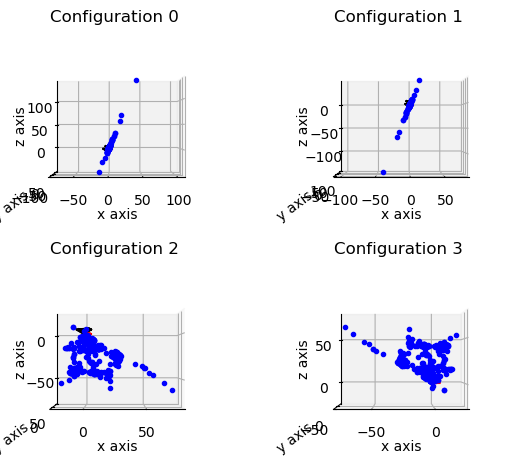

In [101]:
if __name__ == '__main__':
    # read in left and right images as RGB images
    img_left = cv2.imread('./left.bmp', 1)
    img_right = cv2.imread('./right.bmp', 1)
    # visualize_img_pair(img_left, img_right)

    # img_left = cv2.imread('./right.bmp', 1)
    # img_right = cv2.imread('./left.bmp', 1)

    # Step 0: get correspondences between image pair
    data = np.load('./correspondence.npz')
    pts1, pts2 = data['pts1'], data['pts2']
    # visualize_find_match(img_left, img_right, pts1, pts2)

    # Step 1: compute fundamental matrix and recover four sets of camera poses
    F = compute_F(pts1, pts2)
    visualize_epipolar_lines(F, pts1, pts2, img_left, img_right)

    K = np.array([[350, 0, 960/2], [0, 350, 540/2], [0, 0, 1]])
    Rs, Cs = compute_camera_pose(F, K)
    visualize_camera_poses(Rs, Cs)

    # Step 2: triangulation
    pts3Ds = []
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    for i in range(len(Rs)):
        P2 = K @ np.hstack((Rs[i], -Rs[i] @ Cs[i]))
        pts3D = triangulation(P1, P2, pts1, pts2)
        pts3Ds.append(pts3D)
    visualize_camera_poses_with_pts(Rs, Cs, pts3Ds)

    # # Step 3: disambiguate camera poses
    # R, C, pts3D = disambiguate_pose(Rs, Cs, pts3Ds)

    # # Step 4: rectification
    # H1, H2 = compute_rectification(K, R, C)
    # img_left_w = cv2.warpPerspective(img_left, H1, (img_left.shape[1], img_left.shape[0]))
    # img_right_w = cv2.warpPerspective(img_right, H2, (img_right.shape[1], img_right.shape[0]))
    # visualize_img_pair(img_left_w, img_right_w)

    # # Step 5: generate disparity map
    # img_left_w = cv2.resize(img_left_w, (int(img_left_w.shape[1] / 2), int(img_left_w.shape[0] / 2)))  # resize image for speed
    # img_right_w = cv2.resize(img_right_w, (int(img_right_w.shape[1] / 2), int(img_right_w.shape[0] / 2)))
    # img_left_w = cv2.cvtColor(img_left_w, cv2.COLOR_BGR2GRAY)  # convert to gray scale
    # img_right_w = cv2.cvtColor(img_right_w, cv2.COLOR_BGR2GRAY)
    # data = np.load('./resource/hw5/dsift_descriptor.npz')
    # desp1, desp2 = data['descriptors1'], data['descriptors2']
    # disparity = dense_match(img_left_w, img_right_w, desp1, desp2)
    # visualize_disparity_map(disparity)